<a href="https://colab.research.google.com/github/Simoni2412/Dark_Circles_Detection/blob/main/NoML_DarkCircle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install a specific, compatible version of OpenCV
!pip install opencv-contrib-python-headless==4.8.0.74
# Install a specific, compatible version of numpy
!pip install numpy==1.24.3

!pip install --upgrade --force-reinstall mediapipe==0.10.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import cv2
import numpy as np
import os

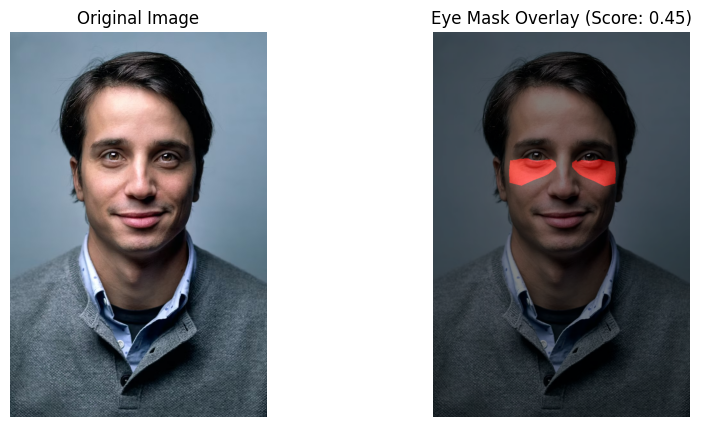

Calculated Eye Region Intensity Score: 0.45


In [3]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from pathlib import Path

# Define landmark indices for LEFT and RIGHT eye regions (using outer contours)
LEFT_EYE_IDXS = [
    35, 226, 7, 163, 144, 145, 153, 154, 243, 244, 245, 188, 114, 47, 100, 101, 50, 123, 116, 143]  # Left eye outer contour4

RIGHT_EYE_IDXS = [
    463, 464, 465, 412, 343, 277, 329, 330, 280, 352, 345, 372, 249, 390, 373, 374, 380, 381, 341 # Right eye outer contour
]
mp_face_mesh = mp.solutions.face_mesh

def get_landmark_coords(image, landmarks, indexes):
    h, w = image.shape[:2]
    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)

def different_zones(image, landmarks):
    h, w = image.shape[:2]
    left_eye_pts = get_landmark_coords(image, landmarks.landmark, LEFT_EYE_IDXS)
    right_eye_pts = get_landmark_coords(image, landmarks.landmark, RIGHT_EYE_IDXS)
    left_eye_mask_full = np.zeros((h, w), dtype=np.uint8)
    right_eye_mask_full = np.zeros((h, w), dtype=np.uint8)
    if left_eye_pts.size > 0:
        cv2.fillPoly(left_eye_mask_full, [np.array(left_eye_pts, dtype=np.int32)], 255)
    if right_eye_pts.size > 0:
        cv2.fillPoly(right_eye_mask_full, [np.array(right_eye_pts, dtype=np.int32)], 255)
    left_eye_segment = cv2.bitwise_and(image, image, mask=left_eye_mask_full)
    right_eye_segment = cv2.bitwise_and(image, image, mask=right_eye_mask_full)
    return left_eye_segment, right_eye_segment, left_eye_mask_full, right_eye_mask_full

def calculate_intensity_by_mask(image: np.ndarray, mask: np.ndarray) -> float:
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    roi = gray[mask > 0]
    if roi.size == 0:
        return 0.0
    low_quantile = np.quantile(roi, 0.25)
    high_quantile = np.quantile(roi, 0.75)
    roi_dropped_quantile = roi[(roi >= low_quantile) & (roi <= high_quantile)]
    return roi_dropped_quantile.mean() if roi_dropped_quantile.size > 0 else 0.0

def detect_dark_circles_quantile(image_path):
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return None, None, None
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = original_image.shape[:2]
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        print(f"No face detected in {image_path}.")
        return original_image, np.zeros((h_orig, w_orig), dtype=np.uint8), 0.0
    landmarks = results.multi_face_landmarks[0]
    left_segment, right_segment, left_eye_mask_full, right_eye_mask_full = different_zones(original_image, landmarks)
    left_eye_intensity = calculate_intensity_by_mask(original_image, left_eye_mask_full)
    right_eye_intensity = calculate_intensity_by_mask(original_image, right_eye_mask_full)

    # left_cheek_mask = get_cheek_mask(original_image, landmarks, LEFT_EYE_IDXS)
    # right_cheek_mask = get_cheek_mask(original_image, landmarks, RIGHT_EYE_IDXS)
    # left_cheek_intensity = calculate_intensity_by_mask(original_image, left_cheek_mask)
    # right_cheek_intensity = calculate_intensity_by_mask(original_image, right_cheek_mask)

    # # Relative dark circle score: cheek - eye
    # left_relative = left_cheek_intensity - left_eye_intensity
    # right_relative = right_cheek_intensity - right_eye_intensity
    # dark_circle_score = (left_relative + right_relative) / 2

    dark_circle_score = (left_eye_intensity + right_eye_intensity) / 2
    dark_circle_score = 1.0 - (dark_circle_score / 255.0)
    combined_eye_mask = cv2.bitwise_or(left_eye_mask_full, right_eye_mask_full)

    return original_image, combined_eye_mask, dark_circle_score


def get_cheek_mask(image, landmarks, eye_idxs, offset_y=20, height=20):
    # Get the bounding box of the eye
    eye_pts = get_landmark_coords(image, landmarks.landmark, eye_idxs)
    if eye_pts.size == 0:
        return np.zeros(image.shape[:2], dtype=np.uint8)
    x, y, w, h = cv2.boundingRect(eye_pts)
    # Cheek region: just below the eye
    cheek_y1 = min(y + h + offset_y, image.shape[0]-1)
    cheek_y2 = min(cheek_y1 + height, image.shape[0])
    cheek_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cheek_mask[cheek_y1:cheek_y2, x:x+w] = 255
    return cheek_mask


# --- Example Usage ---
if __name__ == "__main__":
    # Replace with your image path
    sample_image_for_dark_circles = "/content/face.jpg"
    original_img, eye_mask, score = detect_dark_circles_quantile(sample_image_for_dark_circles)
    if original_img is not None and eye_mask is not None:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        overlay = np.zeros_like(original_img, dtype=np.uint8)
        overlay[eye_mask > 0] = [0, 0, 255]
        alpha = 0.5
        overlaid_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)
        plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Eye Mask Overlay (Score: {score:.2f})')
        plt.axis('off')
        plt.show()
        print(f"Calculated Eye Region Intensity Score: {score:.2f}")
    else:
        print("Could not process the image for dark circle detection.")